<a href="https://colab.research.google.com/github/vinit-narula/AI-ML/blob/main/5_image_classfn_w_o_augmentn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Briefs
1. Import package
2. Data loading
3. Data understanding
4. Setting Model parameters
5. Data preparation
6. Data visualization
7. Build Model
8. Compile Model
9. Train Model
10. Result Visualization





###Importing packages

Import required packages:

os — to read files and directory structure <br> 
numpy — for some matrix math outside of TensorFlow<br> 
matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

###Data Loading

The dataset we are using is a filtered version of Dogs vs. Cats dataset from Kaggle.<br>
In this Colab however, we will make use of the class tf.keras.preprocessing.image.ImageDataGenerator which will read data from disk. We therefore need to directly download Dogs vs. Cats from a URL and unzip it to the Colab filesystem.

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


The dataset we have downloaded has the following directory structure.

cats_and_dogs_filtered<br>
train <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]<br>
validation<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]<br>


In [7]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


Assign variables with the proper file path for the training and validation sets.

What is path join in python?

Join various path components <br>
path = "/home" <br> 
print(os.path.join(path, "User/Desktop", "file.txt")) 

output: /home/User/Desktop/file.txt

In [8]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

###Understanding our data

In [10]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


###Setting Model Parameters

In [12]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

###Data Preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:
<ol>
<li>Read images from the disk
<li>Decode contents of these images and convert it into proper grid format as per their RGB content
<li>Convert them into floating point tensors
<li>Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.
<ol>
Fortunately, all these tasks can be done using the class <b> tf.keras.preprocessing.image.ImageDataGenerator.</b>

In [13]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

In [14]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [15]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


###Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

In [16]:
sample_training_images, _ = next(train_data_gen) 

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

In [17]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

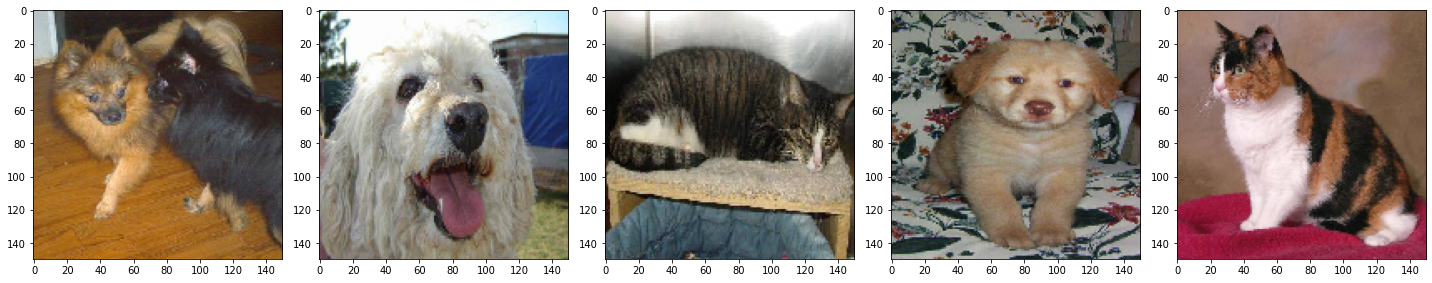

In [18]:
plotImages(sample_training_images[:5])  # Plot images 0-4

###Model Creation

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

###Compile the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

###Model Summary
Let's look at all the layers of our network using summary method.

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

###Train the model

In [22]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 16s 421ms/step - loss: 0.7681 - accuracy: 0.5062 - val_loss: 0.6903 - val_accuracy: 0.5090
Epoch 2/100
20/20 [==============================] - 8s 403ms/step - loss: 0.6902 - accuracy: 0.5329 - val_loss: 0.6779 - val_accuracy: 0.5710
Epoch 3/100
20/20 [==============================] - 8s 402ms/step - loss: 0.6645 - accuracy: 0.5817 - val_loss: 0.6293 - val_accuracy: 0.6390
Epoch 4/100
20/20 [==============================] - 8s 406ms/step - loss: 0.6664 - accuracy: 0.5875 - val_loss: 0.6374 - val_accuracy: 0.6270
Epoch 5/100
20/20 [==============================] - 8s 404ms/step - loss: 0.6260 - accuracy: 0.6427 - val_loss: 0.6094 - val_accuracy: 0.6480
Epoch 6/100
20/20 [==============================] - 8s 410ms/step - loss: 0.5534 - accuracy: 0.7154 - val_loss: 0.6031 - val_accuracy: 0.6780
Epoch 7/100
20/20 [==============================] - 8s 416ms/step - loss: 0.5132 - accuracy: 0.7419 - val_loss: 0.5917 - val_accuracy: 0.674

###Visualizing results of the training

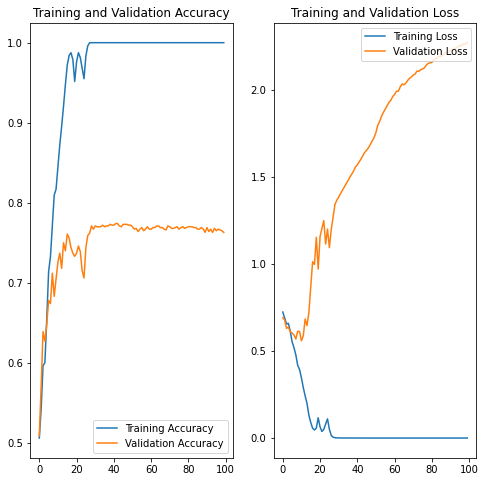

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()